# Problem Set 3

Ari Boyarsky

aboyarsky@uchicago.edu

First we import requisite packages:

In [559]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as sts
from scipy import integrate
from scipy.stats import lognorm
import numpy.linalg as la
import math

### Problem 1

**Part (a)** Plota histogram of *income.txt* with 30 bins.

In [560]:
incomes = pd.read_csv("incomes.txt", header = None)
incomes.rename(columns={0: 'Income'}, inplace=True)
incomes.head()

,Income
0,53711.544399
1,99731.233349
2,84773.605417
3,75184.025931
4,73390.955933


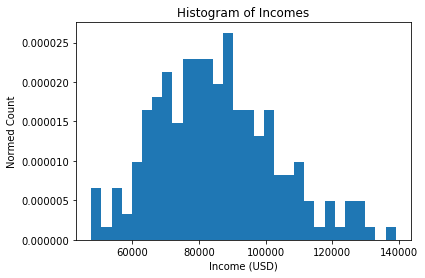

In [561]:
plt.hist(incomes["Income"], bins = 30, normed=True)
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.show()

**Part (b)** Estimate lognormal parameters using GMM. Using avg income, and std. dev. of income as two momemnts. Let $\hat{\textbf{W}} = \textbf{I}$. Plot estimated pdf against histogram.

We use the lognormal pdf from the previous problem set.

In [562]:
# PDF of log norm
def log_norm(x, mu, var):
    '''
    --------------------------------------------------------------------
    This function simulates a log normal pdf with mean mu 
    and variance sigma^2.  
    --------------------------------------------------------------------
    INPUTS:
    x: vector (array), log normally dist. rand var
    mu: scalar, log normal mean
    var: scalar > 0, variance of log normal
    --------------------------------------------------------------------
    RETURNS: value of pdf
    --------------------------------------------------------------------
    '''
    sigma = np.sqrt(var)
    return ((1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-(((np.log(x)-mu)**2)/(2*(sigma**2)))))
    

Now, we define our criterion function:

In [563]:
# This section is heavily based on lecture notes by Dr. Rick Evans (Winter 2018).

def data_moments(x):
    mean = np.log(x).mean()
    var = np.log(x).var()
    
    return mean, var

def model_moments(mu, var):
    # expection of x ~ LN, then E(x) = int(xf(x))
    xfx = lambda y: y * log_norm(y, mu, var)
    (mean, e) = integrate.quad(xfx, 1e-10, np.inf)
    
    # Recall, variance is given by Var(X) = E(X)^2 - E(X^2) = E(X^2 - mu), thus
    x2fx = lambda y: ((y-mean)**2) * log_norm(y, mu, var)
    (variance, e) = integrate.quad(x2fx, 1e-10, np.inf)
    return mean, variance

def errs(x, mu, var):
    mean_data, var_data = data_moments(x)
    mean_model, var_model = model_moments(mu, var)
    return (np.array([[mean_data], [var_data]]) - np.array([[mean_model], [var_model]]))/np.array([[mean_data], [var_data]])

def criterion(params, *args):
    mu, var = params
    x, W = args 
    err = errs(x, mu, var)
    return np.dot(np.dot(err.T, W), err)


In [564]:
mu = np.log(incomes["Income"].values).mean()
var = np.log(incomes["Income"].values).var()
params = np.array([mu, var])
res = minimize(criterion, params, args=(incomes["Income"].values, np.eye(2)), method='L-BFGS-B', bounds=((None, None), (0.001, None)))

In [565]:
res.x

array([ 11.33144034,   0.04480613])

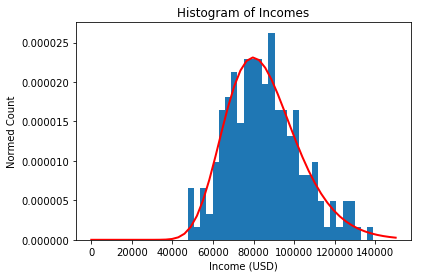

In [566]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.show()

In [567]:
gmm_b_mu, gmm_b_var = res.x
mean_data, var_data = data_moments(incomes["Income"])
mean_model, var_model = model_moments(res.x[0], res.x[1])
err = errs(incomes["Income"], res.x[0], res.x[1]).reshape(2,)
print('Data Mean  =', mean_data, ', Data Var =', var_data)
print('Model Mean =', mean_model, ', Model Var =', var_model)
print('Error vector=', err)
res

Data Mean  = 11.331440335473287 , Data Var = 0.04503128738631155
Model Mean = 1.2355744561578496e-127 , Model Var = 5.771743125631222e-125
Error vector= [ 1.  1.]


      fun: array([[ 2.]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([ 11.33144034,   0.04480613])

Thus, the estmated GMM parameter values are $\mu = 11.331$ and $\text{variance} = 0.0448$. The data parameters are $\mu = $ and variance $= $. The two data and model moments are very far apart which makes little sense. However the estimated results estimate the distribution well.

**Part (c)** Two step GMM.

In [568]:
err1 = errs(incomes["Income"], res.x[0], res.x[1])
VCV = np.dot(err1, err1.T) / incomes["Income"].shape[0]
W = la.pinv(VCV) 
params = np.array([res.x[0], res.x[1]])
results = minimize(criterion, params, args=(incomes["Income"], W),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

In [569]:
mean_data, var_data = data_moments(incomes["Income"])
mean_model, var_model = model_moments(res.x[0], res.x[1])
err = errs(incomes["Income"], res.x[0], res.x[1]).reshape(2,)
print('Data Mean  =', mean_data, ', Data Var =', var_data)
print('Model Mean =', mean_model, ', Model Var =', var_model)
print('Error vector=', err)
res

Data Mean  = 11.331440335473287 , Data Var = 0.04503128738631155
Model Mean = 1.2355744561578496e-127 , Model Var = 5.771743125631222e-125
Error vector= [ 1.  1.]


      fun: array([[ 2.]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([ 11.33144034,   0.04480613])

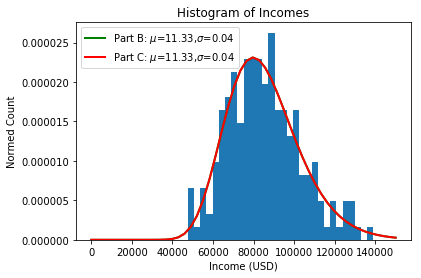

In [570]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, gmm_b_mu, gmm_b_var),
         linewidth=2, color='g', label='Part B: $\mu$='+ str(gmm_b_mu.round(2))+',$\sigma$='+ str(gmm_b_var.round(2)))
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='Part C: $\mu$='+ str(res.x[0].round(2))+',$\sigma$='+ str(res.x[1].round(2)))
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.legend()
plt.show()

**Part (d)** Using percent of individuals who earn less than $75,000, between $75,000 and $100,000 and more than $100,000 as moments.

In [580]:
def new_data_moments(x):
    N = len(x)
    i = np.array(x)
    m_un = sum(i < 75000)/N
    m_bet = np.all((i >= 75000, i <= 100000), axis = 0).sum()/N
    m_up = sum(i > 100000)/N
    
    return m_un, m_bet, m_up

def cdf_LN(x, mu, var):
    return integrate.quad(lambda x: log_norm(x, mu, var), 0, x)

def new_model_moments(mu, var):
    m_un = cdf_LN(75000, mu, var)[0]
    m_bet = cdf_LN(100000, mu, var)[0] - m_un
    m_up = 1 - cdf_LN(100000, mu, var)[0]
    return m_un, m_bet, m_up

def new_errs(x, mu, var):
    md = np.array(new_data_moments(x)).reshape((3,1))
    mm = np.array(new_model_moments(mu, var)).reshape((3,1))
    return (md - mm)/md

def new_criterion(params, *args):
    mu, var = params
    x, W = args 
    err = new_errs(x, mu, var)
    return err.T @ W @ err

In [581]:
mu = np.log(incomes["Income"].values).mean()
var = np.log(incomes["Income"].values).var()
params = np.array([11, 0.5])
resd = minimize(new_criterion, params, args=(incomes["Income"].values, np.eye(3)), method='L-BFGS-B', bounds=((None, None), (0.001, None)))

In [582]:
resd.x

array([ 11.33568134,   0.04435172])

In [583]:
under, between, over = new_data_moments(incomes["Income"])
under_model, between_model, over_model = new_model_moments(resd.x[0], resd.x[1])
err = errs(incomes["Income"], resd.x[0], resd.x[1]).reshape(2,)
print('Data: Under 75:  =', under, ', Data Between 75-100 =', between, ', Over 100k = ',over)
print('Data: Under 75:  =', under_model, ', Data Between 75-100 =', between_model, ', Over 100k = ',over_model)
print('Error vector=', err)
resd

Data: Under 75:  = 0.3 , Data Between 75-100 = 0.5 , Over 100k =  0.2
Data: Under 75:  = 0.2999999995546368 , Data Between 75-100 = 0.4999999665074086 , Over 100k =  0.20000003393795462
Error vector= [ 1.  1.]


      fun: array([[  3.32838377e-14]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.93475805e-06,   8.87104589e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 66
      nit: 10
   status: 0
  success: True
        x: array([ 11.33568134,   0.04435172])

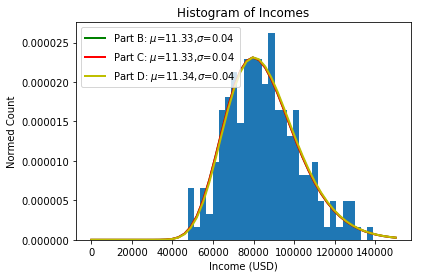

In [590]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, gmm_b_mu, gmm_b_var),
         linewidth=2, color='g', label='Part B: $\mu$='+ str(gmm_b_mu.round(2))+',$\sigma$='+ str(gmm_b_var.round(2)))
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='Part C: $\mu$='+ str(res.x[0].round(2))+',$\sigma$='+ str(res.x[1].round(2)))
plt.plot(x, log_norm(x, resd.x[0], resd.x[1]),
         linewidth=2, color='y', label='Part D: $\mu$='+ str(resd.x[0].round(2))+',$\sigma$='+ str(resd.x[1].round(2)))
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.legend()
plt.show()

**Part (e)** Two step of **(d)**.

In [586]:
errd = new_errs(incomes["Income"], resd.x[0], resd.x[1])
VCV = np.dot(errd, errd.T) / incomes["Income"].shape[0]
W = la.pinv(VCV) 
params = np.array([resd.x[0], resd.x[1]])
results_e = minimize(new_criterion, params, args=(incomes["Income"], W),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

In [588]:
under, between, over = new_data_moments(incomes["Income"])
under_model, between_model, over_model = new_model_moments(results_e.x[0], results_e.x[1])
err = errs(incomes["Income"], results_e.x[0], results_e.x[1]).reshape(2,)
print('Data: Under 75:  =', under, ', Data Between 75-100 =', between, ', Over 100k = ',over)
print('Data: Under 75:  =', under_model, ', Data Between 75-100 =', between_model, ', Over 100k = ',over_model)
print('Error vector=', err)
results_e

Data: Under 75:  = 0.3 , Data Between 75-100 = 0.5 , Over 100k =  0.2
Data: Under 75:  = 0.3000000567530757 , Data Between 75-100 = 0.4999999553651388 , Over 100k =  0.19999998788178552
Error vector= [ 1.  1.]


      fun: array([[ 3.7915856]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.48125141e+08,   1.01633101e+10])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 258
      nit: 4
   status: 2
  success: False
        x: array([ 11.33568131,   0.04435172])

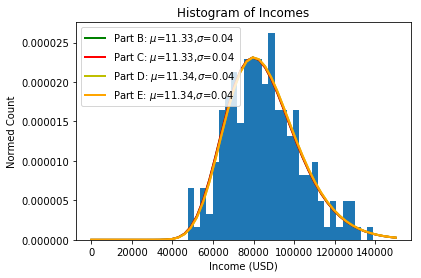

In [594]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, gmm_b_mu, gmm_b_var),
         linewidth=2, color='g', label='Part B: $\mu$='+ str(gmm_b_mu.round(2))+',$\sigma$='+ str(gmm_b_var.round(2)))
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='Part C: $\mu$='+ str(res.x[0].round(2))+',$\sigma$='+ str(res.x[1].round(2)))
plt.plot(x, log_norm(x, resd.x[0], resd.x[1]),
         linewidth=2, color='y', label='Part D: $\mu$='+ str(resd.x[0].round(2))+',$\sigma$='+ str(resd.x[1].round(2)))
plt.plot(x, log_norm(x, results_e.x[0], results_e.x[1]),
         linewidth=2, color='orange', label='Part E: $\mu$='+ str(results_e.x[0].round(2))+',$\sigma$='+ str(results_e.x[1].round(2)))
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.legend()
plt.show()

**Part (f)** All four estimates are extremely simmilar. Indeed, they each minimize distance at almost the same parameter. That said I would choose part c's method as mean and variance are perhaps more robust and standard moment choices. It aso uses two step and is almost exactly on the data mean and variance, just slightly more accurate than the other methods.


## Question 2

**Part (a)**

In [595]:
sick = pd.read_csv("sick.txt")
sick.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [607]:
def ols_data_moment(x):
    m = x["sick"].values
    return m

def ols_model_moment(x, betas):
    N = x.shape[0]
    X = np.concatenate((np.ones((N,1)),x.values[:,1:]), axis = 1)
    return X @ betas

def ols_errs(x, betas, W):
    errors = ols_model_moment(x, betas) - ols_data_moment(x)
    return errors.T @ W @ errors
def ols_crit(params, *args):
    betas = params
    x, W = args 
    return ols_errs(x, betas, W)
   

In [615]:
betas_init = np.array([1,1,1,1])
ols_res = minimize(ols_crit, betas_init, args=(sick, np.eye(len(sick))), method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (None, None)))

In [620]:
for i in range(0, len(ols_res.x)):
    print("Beta "+ str(i) +" = "+ str(ols_res.x[i]))

Beta 0 = 0.251644217151
Beta 1 = 0.0129333956393
Beta 2 = 0.400501622583
Beta 3 = -0.00999164445085


Notice, that these are the same values that we calculated using MLE.

In [613]:
data_m = ols_data_moment(sick)
model_m= ols_model_moment(sick, ols_res.x)
err_ols = ols_errs(sick, ols_res.x, np.eye(len(sick)))
print('Data Moment:  =', data_m)
print('Model Moment:  =', model_m)
print('Error vector=', err)
ols_res

Data Moment:  = [ 1.67  0.71  1.39  1.37  1.45  0.62  1.06  1.29  1.05  1.18  1.21  0.63
  0.67  0.64  0.86  1.25  0.88  0.12  1.53  1.36  0.73  0.15  0.6   1.28
  0.89  0.46  1.03  0.42  0.6   1.86  1.1   1.35  1.11  2.04  0.89  0.69
  1.58  0.86  0.81  0.81  1.04  1.68  1.36  0.37  1.05  2.8   1.03  1.22
  1.83  1.25  1.02  0.89  1.98  1.51  1.14  1.18  0.79  1.66  1.21  0.5
  1.51  0.81  0.64  1.35  0.2   0.66  1.04  1.88  0.55  1.01  0.81  0.95
  1.27  0.78  0.9   0.96  0.79  0.56  1.81  1.63  0.63  0.91  0.66  0.53
  0.96  2.11  0.07  0.59  1.15  0.11  1.06  1.72  0.26  0.93  1.61  1.48
  0.65  1.58  1.16  0.14  0.96  0.65  0.12  0.12  0.86  0.08  1.92  1.56
  1.49  1.32  0.13  1.34  0.61  0.97  0.65  0.49  1.18  0.88  0.46  1.42
  0.56  0.95  1.52  1.2   1.16  1.3   1.22  0.54  1.47  1.97  0.51  0.05
  1.12  0.99  0.91  0.87  0.7   2.12  0.5   0.65  0.8   0.04  2.11  0.78
  0.23  0.4   1.19  1.09  2.22  0.79  1.66  1.28  1.9   1.61  0.93  1.11
  0.74  1.68  1.72  0.27  0.2   0.57

      fun: 0.0018212898261221629
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.27634922e-05,   3.82880576e-03,   1.30814955e-04,
         4.91669741e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 110
      nit: 14
   status: 0
  success: True
        x: array([ 0.25164422,  0.0129334 ,  0.40050162, -0.00999164])